In [1]:
import libsbml
from utils import functions
from utils import graph_functions
from utils import complete_tests
import random
import pickle
import numpy as np
import os 
from collections import defaultdict
from copy import deepcopy

In [3]:
partial_results = {
    'total_species': 0,
    'uncertain_species': 0,
    'correct_species': 0,
    'true_positives': 0,
    'false_positives': 0,
    'false_negatives': 0,
    'true_negatives': 0
}
results_path = '../../../results/real_dataset/small_class/results'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

In [4]:
results_path = '../../../results/real_dataset/small_class/results'
results_file = open(results_path, 'rb')
partial_results = pickle.load(results_file)
results_file.close()
partial_results

{'total_species': 0,
 'uncertain_species': 0,
 'correct_species': 0,
 'true_positives': 0,
 'false_positives': 0,
 'false_negatives': 0,
 'true_negatives': 0}

In [2]:
def convert_sbml_to_network(file_path):
    description = {
    'species': [],
    'reactions': [],
    'connections': [],
    'altered': ''
    }
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_path)
    if document.getNumErrors() > 0:
        print("Errors occurred while loading the SBML file.")
    model = document.getModel()
    
    num_reactions = model.getNumReactions()
    num_species = model.getNumSpecies()
    
    print('number reactions', model.getNumReactions())
    print('number species', model.getNumSpecies()) 
    
    for i in range(num_species):
        description['species'].append(model.getSpecies(i).getId())
    
    for i in range(num_reactions):
        description['reactions'].append([model.getReaction(i).getId(), 0, 1, []])
        num_reactants = model.getReaction(i).getNumReactants()
        num_products = model.getReaction(i).getNumProducts()
        formula = model.getReaction(i).getKineticLaw().getFormula()
        formula = formula.replace('(','')
        formula = formula.replace(' ', '')
        formula_splitted = formula.split('-')
        
        # Add also modifiers to the list 
        num_modifiers = model.getReaction(i).getNumModifiers()
        for m in range(num_modifiers):
            print(model.getReaction(i), ' modifiers: ', model.getReaction(i).getModifier(m).getSpecies())
            description['reactions'][i][-1].append(model.getReaction(i).getModifier(m).getSpecies())
        
        if len(formula_splitted) == 2:
            description['reactions'].append([str(model.getReaction(i).getId() + 'revert'), 0, 1, []])
        
        for j in range(num_reactants):
            reactant = model.getReaction(i).getReactant(j).getSpecies()
            description['connections'].append([reactant, model.getReaction(i).getId()])
            if len(formula_splitted) == 2:
                description['connections'].append([str(model.getReaction(i).getId() + 'revert'), reactant])
            
        for k in range(num_products):
            product = model.getReaction(i).getProduct(k).getSpecies()
            description['connections'].append([model.getReaction(i).getId(), product])
            if len(formula_splitted) == 2:
                description['connections'].append([product, str(model.getReaction(i).getId() + 'revert')])
                
    return description

In [3]:
description = convert_sbml_to_network('BIOMD0000000072.xml')

number reactions 7
number species 7
<Reaction reaction_4 "G-protein Activation">  modifiers:  RL


In [11]:
description

{'species': ['L', 'R', 'G', 'Gbg', 'Gd', 'Ga', 'RL'],
 'reactions': [['reaction_0', 0, 1, []],
  ['reaction_0revert', 0, 1, []],
  ['reaction_1', 0, 1, []],
  ['reaction_2', 0, 1, []],
  ['reaction_3', 0, 1, ['RL']],
  ['reaction_4', 0, 1, []],
  ['reaction_5', 0, 1, []],
  ['reaction_6', 0, 1, []]],
 'connections': [['L', 'reaction_0'],
  ['reaction_0revert', 'L'],
  ['R', 'reaction_0'],
  ['reaction_0revert', 'R'],
  ['reaction_0', 'RL'],
  ['RL', 'reaction_0revert'],
  ['reaction_1', 'R'],
  ['R', 'reaction_2'],
  ['Gd', 'reaction_3'],
  ['Gbg', 'reaction_3'],
  ['reaction_3', 'G'],
  ['G', 'reaction_4'],
  ['reaction_4', 'Ga'],
  ['reaction_4', 'Gbg'],
  ['RL', 'reaction_5'],
  ['Ga', 'reaction_6'],
  ['reaction_6', 'Gd']],
 'altered': ''}

In [4]:
def alter_pathway(filename, reaction_number, parameter_number, output_filename):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    
    reaction = model.getReaction(reaction_number)
    kinetic_law = reaction.getKineticLaw()
    parameter = kinetic_law.getParameter(parameter_number)
    parameter.setValue(parameter.getValue() * 100)
    
    modified_sbml = libsbml.writeSBML(document, output_filename)

In [5]:
def generate_test_set(filename, description):
    reader = libsbml.SBMLReader()
    document = reader.readSBML(filename)
    model = document.getModel()
    base_dir = 'altered_pathways2'
    
    i = 0
    num_reactions = model.getNumReactions()
    for j in range(num_reactions):
        reaction = model.getReaction(j)
        kinetic_law = reaction.getKineticLaw()
        num_parameters = kinetic_law.getNumParameters()
        for k in range(num_parameters):
            parameter = kinetic_law.getParameter(k)
            os.makedirs(os.path.join(base_dir, 'reaction' + str(i)), exist_ok=True)
            alteration_dir = os.path.join(base_dir, 'reaction' + str(i), 'reaction_' + str(i) + '_100x.xml')
            alter_pathway('BIOMD0000000072.xml', j, k, alteration_dir)
            
            altered_description = deepcopy(description)
            altered_description['altered'] = altered_description['reactions'][i][0]
            description_dir = os.path.join(base_dir, 'reaction' + str(i), 'description')
            description_file = open(description_dir, 'wb')
            pickle.dump(altered_description, description_file)
            description_file.close()
            i += 1

In [6]:
generate_test_set('BIOMD0000000072.xml', description)

In [7]:
description_path = 'altered_pathways2/reaction6/description'
description_file = open(description_path, 'rb')
temp = pickle.load(description_file)
description_file.close()
temp

{'species': ['L', 'R', 'G', 'Gbg', 'Gd', 'Ga', 'RL'],
 'reactions': [['reaction_0', 0, 1, []],
  ['reaction_0revert', 0, 1, []],
  ['reaction_1', 0, 1, []],
  ['reaction_2', 0, 1, []],
  ['reaction_3', 0, 1, ['RL']],
  ['reaction_4', 0, 1, []],
  ['reaction_5', 0, 1, []],
  ['reaction_6', 0, 1, []]],
 'connections': [['L', 'reaction_0'],
  ['reaction_0revert', 'L'],
  ['R', 'reaction_0'],
  ['reaction_0revert', 'R'],
  ['reaction_0', 'RL'],
  ['RL', 'reaction_0revert'],
  ['reaction_1', 'R'],
  ['R', 'reaction_2'],
  ['Gd', 'reaction_3'],
  ['Gbg', 'reaction_3'],
  ['reaction_3', 'G'],
  ['G', 'reaction_4'],
  ['reaction_4', 'Ga'],
  ['reaction_4', 'Gbg'],
  ['RL', 'reaction_5'],
  ['Ga', 'reaction_6'],
  ['reaction_6', 'Gd']],
 'altered': 'reaction_5'}

In [2]:
total_species = 0
uncertain_species = 0
correct_species = 0
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0 
deltas_normal = []
deltas_uncertain = []

complete_results = defaultdict()
for directory in list(os.listdir('altered_pathways2')):
    if directory == '.DS_Store':
        continue
    dir = os.path.join('altered_pathways2', directory)
    files = os.listdir(dir)
    description_index = 0
    altered_file_index = 0
    
    for i in range(len(files)):
        if files[i] == 'description':
            description_index = i
        elif files[i] != 'description' and files[i] != 'results':
            altered_file_index = i
            
    res = complete_tests.complete_tests2(
            'BIOMD0000000072.xml',
            os.path.join(dir, files[altered_file_index]),
            os.path.join(dir, 'description'),
            []
        )

    
    '''complete_results_path = os.path.join(dir, 'results')
    complete_results_file = open(complete_results_path, 'wb')
    pickle.dump(res, complete_results_file)
    complete_results_file.close()'''
        
    insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=False, threshold=0, ignore_uncertain=False)
    
    total_species += all
    uncertain_species += uncertain
    
    for d in d_normal:
        deltas_normal.append(d)
    for d in d_uncertain:
        deltas_uncertain.append(d)
        
    total_count = 0
    correct_count = 0
    for specie in insights.keys():
        
        if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
            continue
        
        total_count += 1
        if insights[specie][0] == insights[specie][1][0]:
            correct_count += 1
            correct_species += 1
        
        if insights[specie][1][0] == insights[specie][0] == 1:
            true_positives += 1
        elif insights[specie][1][0] == insights[specie][0] == -1:
            true_negatives += 1
        elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
            false_positives += 1
        elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
            false_negatives += 1
        
        
         
    print(directory, ' total species: ', total_count, 'correct species: ', correct_count, 'ratio: ', correct_count/total_count)
    complete_results[directory] = correct_count / total_count
    

Converged at time 6725.0
Converged at time 9267.0
Specie:  L expected result:  increased  normal final:  6.019999999999945e+17  altered final:  6.019999999999996e+17
confidence interval:  [0.9992636400579663, 0.9995029778638352]
deltas coming from simulation:  [5120.0, 0]
Specie:  R expected result:  increased  normal final:  6.999860002927043  altered final:  478.31389589426107
confidence interval:  [0.946700979833934, 0.955678260668264]
deltas coming from simulation:  [471.314035891334, 0]
Specie:  G expected result:  increased  normal final:  9167.100583467947  altered final:  9203.249531709587
confidence interval:  [0.3750433640028494, 0.379348579559801]
deltas coming from simulation:  [36.14894824164003, 0]
Specie:  Gbg expected result:  decreased  normal final:  832.8994165322026  altered final:  796.7504682904965
confidence interval:  [0.6206514204401992, 0.6249566359971515]
deltas coming from simulation:  [-36.14894824170608, 0]
Specie:  Gd expected result:  decreased  normal f

In [3]:
print('total species: ', total_species, 'correct: ', correct_species, ' uncertain: ', uncertain_species, ' true positives: ', true_positives, 'true_negatives: ', true_negatives, ' false_positives: ', false_positives, ' false negatives: ', false_negatives)

total species:  47 correct:  32  uncertain:  1  true positives:  15 true_negatives:  17  false_positives:  8  false negatives:  7


In [7]:
partial_results['total_species'] += total_species
partial_results['uncertain_species'] += uncertain_species
partial_results['correct_species'] += correct_species
partial_results['true_positives'] += true_positives
partial_results['false_positives'] += false_positives
partial_results['true_negatives'] += true_negatives
partial_results['false_negatives'] += false_negatives

In [8]:
partial_results

{'total_species': 47,
 'uncertain_species': 1,
 'correct_species': 31,
 'true_positives': 14,
 'false_positives': 8,
 'false_negatives': 8,
 'true_negatives': 17}

In [9]:
results_path = '../../../results/real_dataset/small_class/results'
results_file = open(results_path, 'wb')
pickle.dump(partial_results, results_file)
results_file.close()

In [15]:
(0.4869302593564828 + 0.5191231566778451) / 2

0.503026708017164

In [4]:
scores = []
for experiment in complete_results.keys():
    scores.append(complete_results[experiment])
print('Average score: ', np.average(np.array(scores)))

Average score:  0.7008928571428572


In [9]:
temp= complete_tests.complete_tests2(
            'BIOMD0000000072.xml',
            'altered_pathways/reaction5/reaction_5_100x.xml',
            'altered_pathways/reaction5/description',
            []
        )

In [10]:
temp_insigghts, total, uncertain = complete_tests.get_insights_confidence_intervals('altered', temp, 1, detailed_classification=True, threshold=0, ignore_uncertain=False)

out of interval, restricting confidence:  5.0 95.0 0.48260809183335873 0.5188620604596798
out of interval, restricting confidence:  7.5 92.5 0.48450339130543296 0.5167042641036835
out of interval, restricting confidence:  10.0 90.0 0.48584934355790627 0.5149071874989922
out of interval, restricting confidence:  12.5 87.5 0.48698699397080475 0.513101398670318
Gd uncertain set to increase
Specie:  L expected result:  increased
confidence interval:  [0.5, 0.5]
deltas coming from simulation:  [2176.0, 1.284170259978387e-29]
Specie:  R expected result:  decreased
confidence interval:  [0.5, 0.5]
deltas coming from simulation:  [-2.4220675746811082e-05, 7.484594177779063e-15]
Specie:  G expected result:  decreased
confidence interval:  [4.619269676758575e-05, 0.00017727988926739547]
deltas coming from simulation:  [-8175.5488768586865, 1.0566122167514713]
Specie:  Gbg expected result:  increased
confidence interval:  [0.9998227201107329, 0.9999538073032322]
deltas coming from simulation:  [8

In [11]:
uncertain

1

In [6]:
description['altered'] = 'Reaction_1'
description

{'species': ['D',
  'DR',
  'DRG_GDP',
  'G_GDP',
  'DRG',
  'GDP',
  'DRG_GTP',
  'GTP',
  'G_GTP',
  'R'],
 'reactions': [['Reaction_1', 0, 1],
  ['Reaction_1revert', 0, 1],
  ['Reaction_2', 0, 1],
  ['Reaction_2revert', 0, 1],
  ['Reaction_3', 0, 1],
  ['Reaction_3revert', 0, 1],
  ['Reaction_4', 0, 1],
  ['Reaction_4revert', 0, 1],
  ['Reaction_5', 0, 1],
  ['Reaction_6', 0, 1]],
 'connections': [['D', 'Reaction_1'],
  ['Reaction_1revert', 'D'],
  ['R', 'Reaction_1'],
  ['Reaction_1revert', 'R'],
  ['Reaction_1', 'DR'],
  ['DR', 'Reaction_1revert'],
  ['DR', 'Reaction_2'],
  ['Reaction_2revert', 'DR'],
  ['G_GDP', 'Reaction_2'],
  ['Reaction_2revert', 'G_GDP'],
  ['Reaction_2', 'DRG_GDP'],
  ['DRG_GDP', 'Reaction_2revert'],
  ['DRG_GDP', 'Reaction_3'],
  ['Reaction_3revert', 'DRG_GDP'],
  ['Reaction_3', 'GDP'],
  ['GDP', 'Reaction_3revert'],
  ['Reaction_3', 'DRG'],
  ['DRG', 'Reaction_3revert'],
  ['DRG', 'Reaction_4'],
  ['Reaction_4revert', 'DRG'],
  ['GTP', 'Reaction_4'],
  ['R

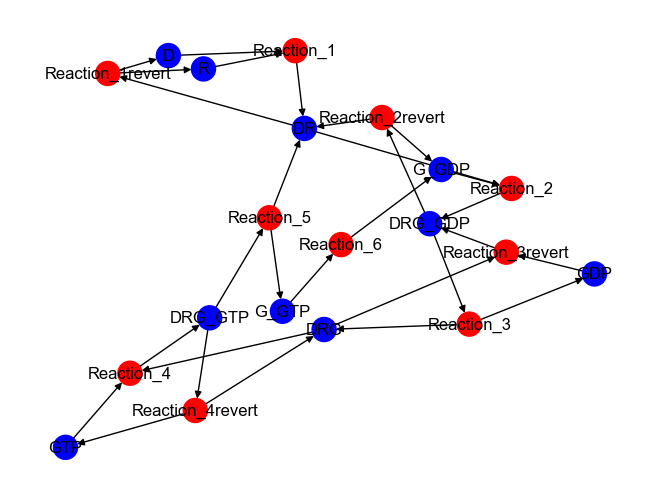

In [7]:
graph = functions.generate_graph(description)
functions.plot_graph(graph)

In [8]:
description_path = 'description_reaction1_altered'
description_file = open(description_path, 'wb')
pickle.dump(description, description_file)
description_file.close()

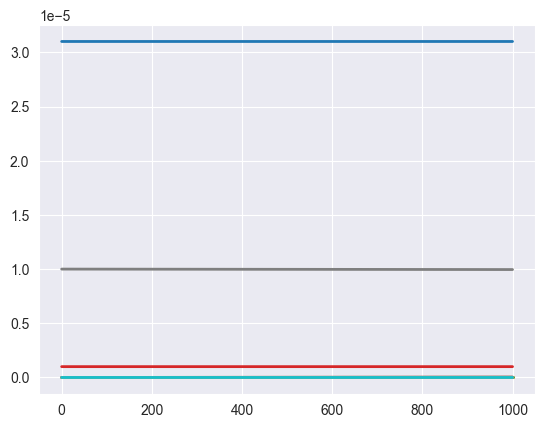

       time,         [D],        [DR],   [DRG_GDP],     [G_GDP],       [DRG],       [GDP],   [DRG_GTP],       [GTP],     [G_GTP],         [R]
 [[       0,     3.1e-05,           0,           0,       1e-06,           0,           0,           0,       1e-05,           0,       1e-10],
  [   1.001, 3.09999e-05,  4.3597e-13, 8.98186e-12, 9.99884e-07, 4.78504e-11, 1.24623e-10, 4.27037e-11, 9.99992e-06, 1.67138e-11, 2.81231e-14],
  [   2.002, 3.09999e-05, 4.37648e-13, 8.58272e-12,  9.9988e-07, 4.80501e-11,  1.6793e-10, 4.29013e-11, 9.99988e-06, 2.08038e-11, 2.82354e-14],
  [   3.003, 3.09999e-05, 4.37656e-13, 8.58057e-12, 9.99879e-07, 4.80513e-11, 2.10877e-10, 4.29022e-11, 9.99984e-06, 2.13645e-11,  2.8236e-14],
  [   4.004, 3.09999e-05, 4.37655e-13, 8.58049e-12, 9.99879e-07, 4.80514e-11, 2.53823e-10, 4.29022e-11, 9.99979e-06, 2.14414e-11, 2.82359e-14],
  [ 5.00501, 3.09999e-05, 4.37653e-13, 8.58072e-12, 9.99879e-07, 4.80514e-11, 2.96767e-10,  4.2902e-11, 9.99975e-06,   2.145e-11, 2.82358e

In [9]:
final_concentrations_normal = functions.plot_simulation_complete('BIOMD0000000080.xml')

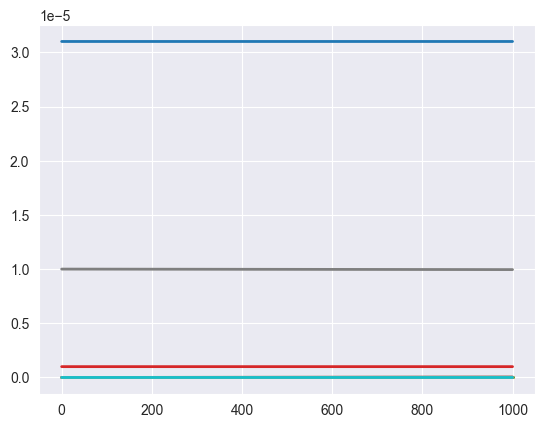

       time,         [D],        [DR],   [DRG_GDP],     [G_GDP],       [DRG],       [GDP],   [DRG_GTP],       [GTP],     [G_GTP],         [R]
 [[       0,     3.1e-05,           0,           0,       1e-06,           0,           0,           0,       1e-05,           0,       1e-10],
  [   1.001, 3.09999e-05, 4.69048e-13, 9.37812e-14,  9.9988e-07, 5.25171e-11, 1.45012e-10, 4.68898e-11, 9.99991e-06, 2.00915e-11, 3.02613e-14],
  [   2.002, 3.09999e-05, 4.69048e-13, 9.37814e-14, 9.99877e-07, 5.25172e-11, 1.91948e-10, 4.68897e-11, 9.99986e-06, 2.30071e-11, 3.02613e-14],
  [   3.003, 3.09999e-05, 4.69047e-13, 9.37817e-14, 9.99877e-07, 5.25173e-11, 2.38885e-10, 4.68896e-11, 9.99981e-06, 2.33837e-11, 3.02612e-14],
  [   4.004, 3.09999e-05, 4.69046e-13,  9.3782e-14, 9.99877e-07, 5.25174e-11, 2.85821e-10, 4.68895e-11, 9.99977e-06, 2.34116e-11, 3.02611e-14],
  [ 5.00501, 3.09999e-05, 4.69045e-13, 9.37822e-14, 9.99877e-07, 5.25176e-11, 3.32758e-10, 4.68894e-11, 9.99972e-06, 2.34173e-11, 3.02611e

In [17]:
final_concentrations_altered = functions.plot_simulation_complete('BIOMD0000000080_reaction1_100x.xml')

In [11]:
species = description['species']
species

['D', 'DR', 'DRG_GDP', 'G_GDP', 'DRG', 'GDP', 'DRG_GTP', 'GTP', 'G_GTP', 'R']

In [12]:
final_normal = final_concentrations_normal[0][-1]
final_altered = final_concentrations_altered[0][-1]

In [13]:
final_normal

[1.00000000e+03 3.09999000e-05 4.36616637e-13 8.60059122e-12
 9.99879067e-07 4.81383000e-11 4.29287568e-08 4.27963233e-11
 9.95711938e-06 2.13981882e-11 2.81689065e-14]

In [14]:
temp = final_concentrations_normal[1]
temp

[3.1e-05 0.0e+00 0.0e+00 1.0e-06 0.0e+00 0.0e+00 0.0e+00 1.0e-05 0.0e+00
 1.0e-10]

In [18]:
import math
expected_results = {}
for i in range(len(species)):
    delta1 = 0
    delta2 = 0
    print(species[i])
    if final_normal[i + 1] != 0:
        if temp[i] != 0:
            initial_concentration = temp[i]
            delta1 = math.fabs((final_altered[i + 1] - final_normal[i + 1]) / initial_concentration)
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta1 * delta2
        else:
            delta2 = math.fabs(1 - (final_altered[i + 1] / final_normal[i + 1]))
            paired_delta = delta2 / 100
            
        relative_delta = (final_altered[i + 1] - final_normal[i + 1]) / final_normal[i + 1]
        
    else: 
        relative_delta = 0
        
    if paired_delta >= 0.001 and final_altered[i + 1] < final_normal[i + 1]:
        expected_results[species[i]] = 'decreased'
    elif paired_delta >= 0.001 and final_altered[i + 1] > final_normal[i + 1]:
        expected_results[species[i]] = 'increased'
    else:
        expected_results[species[i]] = 'unchanged'
    
    print('final normal: ', final_normal[i + 1], 'final altered: ', final_altered[i + 1], 'delta: ', final_altered[i + 1] - final_normal[i + 1], 'relative delta ', relative_delta, 'initial concentration: ', temp[i], 'delta1', delta1, 'delta2', delta2)

D
final normal:  3.099990002816899e-05 final altered:  3.099990000028181e-05 delta:  -2.788717743057792e-14 relative delta  -8.995892698117542e-10 initial concentration:  3.1e-05 delta1 8.9958636872832e-10 delta2 8.995892919472226e-10
DR
final normal:  4.3661663664676783e-13 final altered:  4.367381210875146e-13 delta:  1.2148444074677492e-16 relative delta  0.000278240521661703 initial concentration:  0.0 delta1 0 delta2 0.000278240521661699
DRG_GDP
final normal:  8.600591222166512e-12 final altered:  8.6029965673783e-12 delta:  2.4053452117882116e-15 relative delta  0.0002796720771461452 initial concentration:  0.0 delta1 0 delta2 0.0002796720771460759
G_GDP
final normal:  9.998790665973268e-07 final altered:  9.998790328791413e-07 delta:  -3.37181854855197e-14 relative delta  -3.3722263633606754e-08 initial concentration:  1e-06 delta1 3.37181854855197e-08 delta2 3.372226364817266e-08
DRG
final normal:  4.813829996196359e-11 final altered:  4.815175523147397e-11 delta:  1.3455269510

In [19]:
expected_results

{'D': 'unchanged',
 'DR': 'unchanged',
 'DRG_GDP': 'unchanged',
 'G_GDP': 'unchanged',
 'DRG': 'unchanged',
 'GDP': 'unchanged',
 'DRG_GTP': 'unchanged',
 'GTP': 'unchanged',
 'G_GTP': 'unchanged',
 'R': 'unchanged'}

In [17]:
description['reactions'][0][1] = 0.2

In [18]:
for i in range(len(description['reactions'])):
    description['reactions'][i][2] = random.uniform(0, 1)

In [19]:
graph = graph_functions.generate_graph(description)

In [20]:
species_propagation = []
for i in range(100):
    print("ITERATION ", i)
    species_propagation.append(graph_functions.update_graph(graph, 1, i + 1))

ITERATION  0
---values before iteration---
{'M': 0.5, 'MpY': 0.5, 'MpT': 0.5, 'Mpp': 0.5, 'MAPKK': 0.5, 'MKP': 0.5, 'MpY_MAPKK': 0.5, 'MpT_MAPKK': 0.5, 'M_MAPKK_Y': 0.5, 'M_MAPKK_T': 0.5, 'Mpp_MKP_Y': 0.5, 'Mpp_MKP_T': 0.5, 'MpY_MKP_Y': 0.5, 'MpY_MKP_T': 0.5, 'MpT_MKP_Y': 0.5, 'MpT_MKP_T': 0.5, 'M_MKP_T': 0.5, 'M_MKP_Y': 0.5}
Firing reaction  reaction_0000001
reactant:  M  delta:  0.0
reactant:  MAPKK  delta:  0.0
{'type': 'reaction', 'strength': 0.2, 'weight': 0.31049363849558864}
new reaction strength:  0.0  reaction weight:  0.31049363849558864  reaction strength  0.2
reactant:  M  new value:  0.31002551887238755  delta:  -0.18997448112761245
reactant:  MAPKK  new value:  0.31002551887238755  delta:  -0.18997448112761245
product:  M_MAPKK_Y new value:  0.6899744811276125
Firing reaction  reaction_0000001revert
reactant:  M_MAPKK_Y  delta:  0.0
{'type': 'reaction', 'strength': 0, 'weight': 0.678764660401966}
new reaction strength:  0.0  reaction weight:  0.678764660401966  reaction s

In [21]:
species_propagation

[{'M': 0.31002551887238755,
  'MpY': 0.5,
  'MpT': 0.5,
  'Mpp': 0.5,
  'MAPKK': 0.31002551887238755,
  'MKP': 0.5,
  'MpY_MAPKK': 0.5,
  'MpT_MAPKK': 0.5,
  'M_MAPKK_Y': 0.6899744811276125,
  'M_MAPKK_T': 0.5,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.5,
  'M_MKP_Y': 0.5},
 {'M': 0.6708783557279607,
  'MpY': 0.9422795106044548,
  'MpT': 0.8670982768741314,
  'Mpp': 0.5,
  'MAPKK': 0.5913580924001746,
  'MKP': 0.9290585038041786,
  'MpY_MAPKK': 0.08410755778349127,
  'MpT_MAPKK': 0.13290172312586868,
  'M_MAPKK_Y': 0.09475501814094794,
  'M_MAPKK_T': 0.025746483254046715,
  'Mpp_MKP_Y': 0.5,
  'Mpp_MKP_T': 0.5,
  'MpY_MKP_Y': 0.5,
  'MpY_MKP_T': 0.5,
  'MpT_MKP_Y': 0.5,
  'MpT_MKP_T': 0.5,
  'M_MKP_T': 0.06570426290880449,
  'M_MKP_Y': 0.0761787294828381},
 {'M': 0.04762354052406159,
  'MpY': 0.44484555728100167,
  'MpT': 0.33842444463130605,
  'Mpp': 0.027778923927269716,
  'MAPKK': 0.03456896

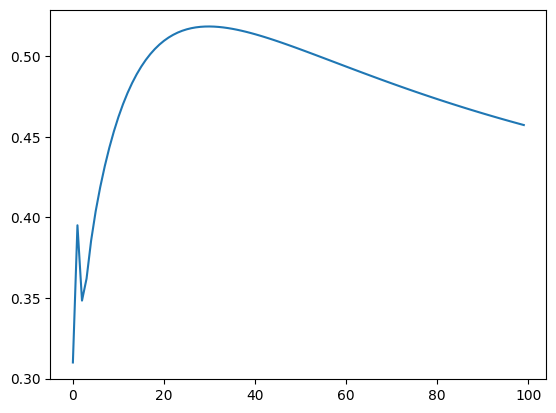

In [74]:
import matplotlib.pyplot as plt
concentrations = [conc['M'] for conc in species_propagation]
concentrations
plt.plot(concentrations[0:500])

In [75]:
final_propagation = species_propagation[-1]
for s in final_propagation.keys():
    print(s, 'propagation results: ', final_propagation[s], 'simulation results: ', expected_results[s])

M propagation results:  0.4573673063139326 simulation results:  increased
MpY propagation results:  0.5859506999350107 simulation results:  increased
MpT propagation results:  0.42683903449371147 simulation results:  increased
Mpp propagation results:  0.38758917256795355 simulation results:  unchanged
MAPKK propagation results:  0.4282587576580072 simulation results:  decreased
MKP propagation results:  0.5468037734808247 simulation results:  increased
MpY_MAPKK propagation results:  0.5034654849769683 simulation results:  unchanged
MpT_MAPKK propagation results:  0.4660739809818277 simulation results:  unchanged
M_MAPKK_Y propagation results:  0.5647061946329963 simulation results:  increased
M_MAPKK_T propagation results:  0.47072859983635107 simulation results:  unchanged
Mpp_MKP_Y propagation results:  0.4835596299636847 simulation results:  unchanged
Mpp_MKP_T propagation results:  0.4836623648528669 simulation results:  unchanged
MpY_MKP_Y propagation results:  0.534006843731000

In [20]:
res = complete_tests.complete_tests2(
            'BIOMD0000000080.xml',
            'BIOMD0000000080_reaction1_100x.xml',
            'description_reaction1_altered',
            []
        )

In [21]:
insights = complete_tests.get_insights_confidence_intervals('altered', res, 1, detailed_classification=True, threshold=0)

Specie:  D expected result:  decreased
confidence interval:  [0.538418229401419, 0.5399212845438157]
Specie:  DR expected result:  increased
confidence interval:  [0.5846070777819418, 0.5862084577298895]
Specie:  DRG_GDP expected result:  increased
confidence interval:  [0.5437229182033395, 0.5459853058416205]
Specie:  G_GDP expected result:  decreased
confidence interval:  [0.4991424085930046, 0.5020573509949865]
Specie:  DRG expected result:  increased
confidence interval:  [0.5493261621312091, 0.5533951160865025]
Specie:  GDP expected result:  increased
confidence interval:  [0.5427947416067058, 0.5455754157199753]
Specie:  DRG_GTP expected result:  increased
confidence interval:  [0.5014605584985282, 0.5016534164843586]
Specie:  GTP expected result:  decreased
confidence interval:  [0.45160110745459975, 0.45556843054731394]
Specie:  G_GTP expected result:  increased
confidence interval:  [0.5019978753900012, 0.50221195501737]
Specie:  R expected result:  decreased
confidence interv

In [22]:
total_count = 0
correct_count = 0
for specie in insights.keys():
    total_count += 1
    if insights[specie][0] == insights[specie][1]:
        correct_count += 1
print('total experiments: ', total_count, 'correct experiments: ', correct_count, 'ratio: ', correct_count/total_count)

total experiments:  10 correct experiments:  7 ratio:  0.7


In [31]:
total_count = 0
correct_count = 0
for specie in insights[2].keys():
    if expected_results[specie] != 'unchanged':
        total_count += 1
    if type(specie) != type(''):
        continue
    print('specie: ', specie)
    scores = np.array(insights[2][specie][-1])
    mean = np.mean(scores)
    std = np.std(scores)
    std_error = std / np.sqrt(len(scores))
    margin = 2 * std_error
    lower = mean - margin
    higher = mean + margin
    print(' lower: ', lower, ' higher: ', higher)
    if lower > 0.5: 
        print('increase, expected: ', expected_results[specie])
        if expected_results[specie] == 'increased':
            correct_count += 1
        
    else: 
        print('decrease, expected: ', expected_results[specie])
        if expected_results[specie] == 'decreased':
            correct_count += 1
print('ratio correct: ', correct_count / total_count, 'correct: ', correct_count, 'total: ', total_count)

specie:  M
 lower:  0.4637417533839022  higher:  0.4673349186799267
decrease, expected:  increased
specie:  MpY
 lower:  0.5991303309472806  higher:  0.6023748512798377
increase, expected:  increased
specie:  MpT
 lower:  0.4718955701272027  higher:  0.4759069512085346
decrease, expected:  increased
specie:  Mpp
 lower:  0.3756636941126044  higher:  0.3789976416682042
decrease, expected:  decreased
specie:  MAPKK
 lower:  0.3602388673451398  higher:  0.36140146766758047
decrease, expected:  decreased
specie:  MKP
 lower:  0.5607346855559303  higher:  0.5631176832807838
increase, expected:  increased
specie:  MpY_MAPKK
 lower:  0.489276800582603  higher:  0.49027261550261664
decrease, expected:  decreased
specie:  MpT_MAPKK
 lower:  0.4604340713427221  higher:  0.4614110647921208
decrease, expected:  decreased
specie:  M_MAPKK_Y
 lower:  0.552772153190489  higher:  0.5540794675295615
increase, expected:  increased
specie:  M_MAPKK_T
 lower:  0.455282023422336  higher:  0.456438765868962

<Axes: ylabel='Count'>

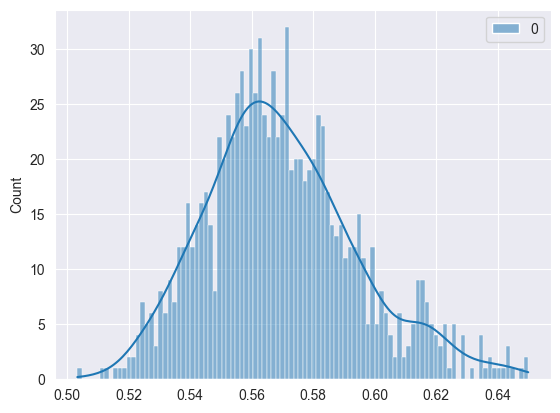

In [30]:
import pandas as pd 
import seaborn as sns
scores = np.array(insights[2]['MpY_MKP_T'][-1])
df = pd.DataFrame(scores)
sns.histplot(df, kde=True, bins=100)